In [2]:
import pandas as pd
import configparser
import boto3

# Load AWS credentials from the configuration file
config = configparser.ConfigParser()
config.read('aws.cfg')

aws_access_key = config['AWS']['aws_access_key_id']
aws_secret_key = config['AWS']['aws_secret_access_key']
location = config['AWS']['region_name']

# Initialize the S3 client
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key
)

# Verify the client is set up correctly by listing buckets
# response = s3.list_buckets()
# print('Existing buckets:')
# for bucket in response['Buckets']:
#     print(f'  {bucket["Name"]}')

In [3]:
# Define the file to download and the target local path
bucket_name = 'techcatalyst-public'

key1 = 'resources/sentiment/product.csv'
filename1 = '/workspaces/boto3_lab/AI API/product.csv'

key2 = 'resources/sentiment/product.csv'
filename2 = '/workspaces/boto3_lab/AI API/review.csv'

# Download the file from S3

s3.download_file(Bucket=bucket_name, Key=key1, Filename=filename1)
s3.download_file(Bucket=bucket_name, Key=key2, Filename=filename2)

# Print a confirmation message
print(f'File {key1} downloaded from bucket {bucket_name} to {filename1}.')
print(f'File {key2} downloaded from bucket {bucket_name} to {filename2}.')

File resources/sentiment/product.csv downloaded from bucket techcatalyst-public to /workspaces/boto3_lab/AI API/product.csv.
File resources/sentiment/product.csv downloaded from bucket techcatalyst-public to /workspaces/boto3_lab/AI API/review.csv.


In [4]:

import awswrangler as wr

boto3.setup_default_session(
    aws_access_key_id=config['AWS']['aws_access_key_id'],
    aws_secret_access_key=config['AWS']['aws_secret_access_key'],
    region_name=config['AWS']['region_name']
)

try:
    df1 = wr.s3.read_csv('s3://techcatalyst-public/resources/sentiment/product.csv') 
except Exception as e:
    print('error')
    print(e)


try:
    df2 = wr.s3.read_csv('s3://techcatalyst-public/resources/sentiment/review.csv') 
except Exception as e:
    print('error')
    print(e)

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PRODUCT ID           20 non-null     int64 
 1   PRODUCT DESCRIPTION  20 non-null     object
 2   REVIEW ID            20 non-null     object
dtypes: int64(1), object(2)
memory usage: 608.0+ bytes


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   REVIEW ID    20 non-null     object
 1   REVIEW TEXT  20 non-null     object
dtypes: object(2)
memory usage: 448.0+ bytes


In [7]:
combined_df = pd.merge(df1, df2, on='REVIEW ID', how='inner')
combined_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   PRODUCT ID           20 non-null     int64 
 1   PRODUCT DESCRIPTION  20 non-null     object
 2   REVIEW ID            20 non-null     object
 3   REVIEW TEXT          20 non-null     object
dtypes: int64(1), object(3)
memory usage: 768.0+ bytes


In [8]:
comprehend = boto3.client('comprehend', region_name=location)

def get_sentiment(text):
    response = comprehend.detect_sentiment(Text=text, LanguageCode='en')
    return response['Sentiment']

combined_df['SENTIMENT'] = combined_df['REVIEW TEXT'].apply(get_sentiment)
combined_df.head(5)

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT,SENTIMENT
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b...",MIXED
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...,POSITIVE
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...,POSITIVE
3,2,Durable laptop with long battery life.,R4,Disappointed with the build quality. Feels cheap.,NEGATIVE
4,3,Wireless noise-canceling headphones.,R5,Fantastic noise cancellation and sound quality.,POSITIVE


**Bar Graph**

In [21]:
!pip install matplotlib

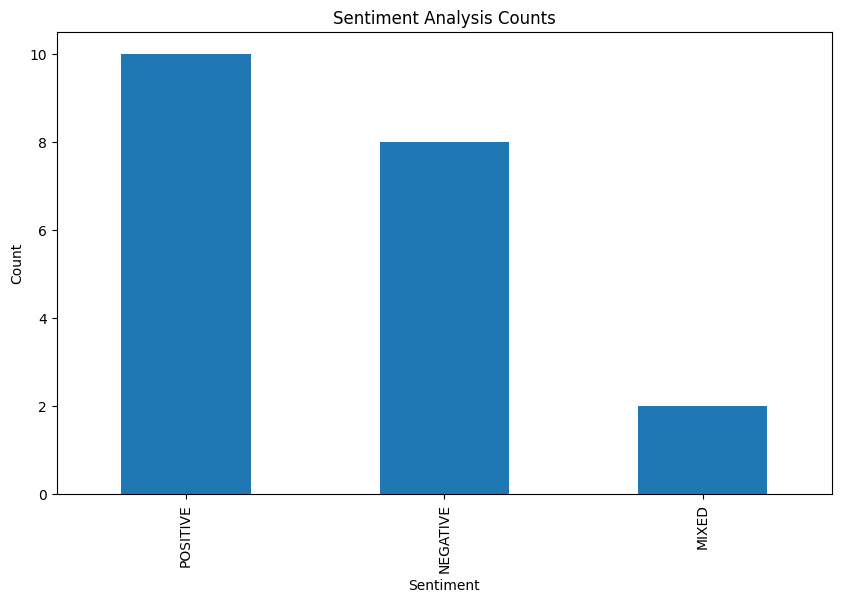

In [9]:
import matplotlib.pyplot as plt

sentiment_counts = combined_df['SENTIMENT'].value_counts()

plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Analysis Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

**Saving dataset to s3**

In [10]:
combined_df.to_csv('product_sentiment.csv', index=False)

In [11]:
# Define the file to upload and the target bucket and key
filename = '/workspaces/boto3_lab/AI API/product_sentiment.csv'  # Replace with your file path
bucket_name = 'techcatalyst-public'  # Replace with your bucket name
key = 'aryan/product_sentiment.csv'  # Replace with your file key in S3

# Upload the file to S3
s3.upload_file(filename, bucket_name, key)

# Print a confirmation message
print(f'File {filename} uploaded to bucket {bucket_name} with key {key}.')

File /workspaces/boto3_lab/AI API/product_sentiment.csv uploaded to bucket techcatalyst-public with key aryan/product_sentiment.csv.


## License Plate State Identification

In [26]:
images = []
bucket_name = 'techcatalyst-public'
key = 'resources/license-plates/'
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=key)
for b in response['Contents']:
    images.append({b["Key"]})
print(images)

[{'resources/license-plates/'}, {'resources/license-plates/license_plate10.jpeg'}, {'resources/license-plates/license_plate11.png'}, {'resources/license-plates/license_plate12.jpeg'}, {'resources/license-plates/license_plate13.jpeg'}, {'resources/license-plates/license_plate3.png'}, {'resources/license-plates/license_plate4.jpeg'}, {'resources/license-plates/license_plate6.jpeg'}, {'resources/license-plates/license_plate7.jpg'}, {'resources/license-plates/license_plate8.png'}, {'resources/license-plates/license_plate9.jpeg'}, {'resources/license-plates/states.csv'}]


In [75]:
import os
# Define the file to download and the target local path
bucket_name = 'techcatalyst-public'
key = 'resources/license-plates/'

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=key)
for b in response['Contents']:
    filename = os.path.join('/workspaces/boto3_lab/AI API/', os.path.basename(b['Key']))
    # print(b['Key'])
    print(filename)


/workspaces/boto3_lab/AI API/
/workspaces/boto3_lab/AI API/license_plate10.jpeg
/workspaces/boto3_lab/AI API/license_plate11.png
/workspaces/boto3_lab/AI API/license_plate12.jpeg
/workspaces/boto3_lab/AI API/license_plate13.jpeg
/workspaces/boto3_lab/AI API/license_plate3.png
/workspaces/boto3_lab/AI API/license_plate4.jpeg
/workspaces/boto3_lab/AI API/license_plate6.jpeg
/workspaces/boto3_lab/AI API/license_plate7.jpg
/workspaces/boto3_lab/AI API/license_plate8.png
/workspaces/boto3_lab/AI API/license_plate9.jpeg
/workspaces/boto3_lab/AI API/states.csv


In [76]:
bucket_name = 'techcatalyst-public'
key = '/resources/license-plates/*'
filename = '/workspaces/boto3_lab/AI API/license_plates'
rekognition = boto3.client('rekognition')

licenses = []
for b in response['Contents']:
    key = b['Key']
    if key.endswith('.jpeg') or key.endswith('.png') or key.endswith('.jpg'):
        response = rekognition.detect_text(Image={'S3Object':{'Bucket':bucket_name, 'Name': key}})
        detected_texts = [text['DetectedText'] for text in response['TextDetections']]
        print(detected_texts)
        licenses.append(detected_texts)
print(licenses)

['ARIZONA', 'AL-A', 'PERM', 'ATE3415', '-', 'GRAND CANYON STATE', '-', 'ARIZONA', 'AL-A', 'PERM', 'ATE3415', '-', 'GRAND', 'CANYON', 'STATE', '-']
['TEXAS', 'BBX', '0228', 'The Lone Star State', 'TEXAS', 'BBX', '0228', 'The', 'Lone', 'Star', 'State']
['TEXAS', 'LQR', 'A216', 'The Lone Star State', '7824966890', 'RGVIVER.COM', 'TEXAS', 'LQR', 'A216', 'The', 'Lone', 'Star', 'State', '7824966890', 'RGVIVER.COM']
['ALABAMA', 'ALABAMA DIXIE ALA', 'HEART', 'RC18351', 'OF', '13', 'MAR', 'GOD BLESS AMERICA', '43-128808', 'ALABAMA', 'ALABAMA', 'DIXIE', 'ALA', 'HEART', 'RC18351', 'OF', '13', 'MAR', 'GOD', 'BLESS', 'AMERICA', '43-128808']
['FEB Massachusetts', 'Massachusetts', '11', '15', 'G2', 'The Spirit of America', 'FEB', 'Massachusetts', 'Massachusetts', '11', '15', 'G2', 'The', 'Spirit', 'of', 'America']
['- -', '37 ! 342 roo', 'ZRZ', 'PENNSYLVANIA', 'DLC', '311', 'BOR.1NG', '001', 'visitPA.com', 'I', '1447702', '-', '-', '37 !', '342', 'roo', 'ZRZ', 'PENNSYLVANIA', 'DLC', '311', 'BOR.1NG',

In [77]:
print(licenses)

[['ARIZONA', 'AL-A', 'PERM', 'ATE3415', '-', 'GRAND CANYON STATE', '-', 'ARIZONA', 'AL-A', 'PERM', 'ATE3415', '-', 'GRAND', 'CANYON', 'STATE', '-'], ['TEXAS', 'BBX', '0228', 'The Lone Star State', 'TEXAS', 'BBX', '0228', 'The', 'Lone', 'Star', 'State'], ['TEXAS', 'LQR', 'A216', 'The Lone Star State', '7824966890', 'RGVIVER.COM', 'TEXAS', 'LQR', 'A216', 'The', 'Lone', 'Star', 'State', '7824966890', 'RGVIVER.COM'], ['ALABAMA', 'ALABAMA DIXIE ALA', 'HEART', 'RC18351', 'OF', '13', 'MAR', 'GOD BLESS AMERICA', '43-128808', 'ALABAMA', 'ALABAMA', 'DIXIE', 'ALA', 'HEART', 'RC18351', 'OF', '13', 'MAR', 'GOD', 'BLESS', 'AMERICA', '43-128808'], ['FEB Massachusetts', 'Massachusetts', '11', '15', 'G2', 'The Spirit of America', 'FEB', 'Massachusetts', 'Massachusetts', '11', '15', 'G2', 'The', 'Spirit', 'of', 'America'], ['- -', '37 ! 342 roo', 'ZRZ', 'PENNSYLVANIA', 'DLC', '311', 'BOR.1NG', '001', 'visitPA.com', 'I', '1447702', '-', '-', '37 !', '342', 'roo', 'ZRZ', 'PENNSYLVANIA', 'DLC', '311', 'BOR

In [89]:
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
state_list = []
for i in state_names:
    state_list.append(i.upper())

license_plates = []
for i in licenses:
    for j in range(len(i)):
        i[j] = i[j].upper()
        license_plates.append(i[j])

state = []
for i in licenses:
    for j in state_list:
        if j in i:
            print(f"Sublist {i} contains {j}")
            state.append(j)
            break


Sublist ['ARIZONA', 'AL-A', 'PERM', 'ATE3415', '-', 'GRAND CANYON STATE', '-', 'ARIZONA', 'AL-A', 'PERM', 'ATE3415', '-', 'GRAND', 'CANYON', 'STATE', '-'] contains ARIZONA
Sublist ['TEXAS', 'BBX', '0228', 'THE LONE STAR STATE', 'TEXAS', 'BBX', '0228', 'THE', 'LONE', 'STAR', 'STATE'] contains TEXAS
Sublist ['TEXAS', 'LQR', 'A216', 'THE LONE STAR STATE', '7824966890', 'RGVIVER.COM', 'TEXAS', 'LQR', 'A216', 'THE', 'LONE', 'STAR', 'STATE', '7824966890', 'RGVIVER.COM'] contains TEXAS
Sublist ['ALABAMA', 'ALABAMA DIXIE ALA', 'HEART', 'RC18351', 'OF', '13', 'MAR', 'GOD BLESS AMERICA', '43-128808', 'ALABAMA', 'ALABAMA', 'DIXIE', 'ALA', 'HEART', 'RC18351', 'OF', '13', 'MAR', 'GOD', 'BLESS', 'AMERICA', '43-128808'] contains ALABAMA
Sublist ['FEB MASSACHUSETTS', 'MASSACHUSETTS', '11', '15', 'G2', 'THE SPIRIT OF AMERICA', 'FEB', 'MASSACHUSETTS', 'MASSACHUSETTS', '11', '15', 'G2', 'THE', 'SPIRIT', 'OF', 'AMERICA'] contains MASSACHUSETTS
Sublist ['- -', '37 ! 342 ROO', 'ZRZ', 'PENNSYLVANIA', 'DLC', 

In [97]:
images_dict = {"Images":images[0:10],
               "State": state}
licenses_df = pd.DataFrame(images_dict)

licenses_df.to_csv('image_state.csv', index=False)

In [98]:
# Define the file to upload and the target bucket and key
filename = '/workspaces/boto3_lab/AI API/image_state.csv'  # Replace with your file path
bucket_name = 'techcatalyst-public'  # Replace with your bucket name
key = 'aryan/image_state.csv'  # Replace with your file key in S3

# Upload the file to S3
s3.upload_file(filename, bucket_name, key)

# Print a confirmation message
print(f'File {filename} uploaded to bucket {bucket_name} with key {key}.')

File /workspaces/boto3_lab/AI API/image_state.csv uploaded to bucket techcatalyst-public with key aryan/image_state.csv.


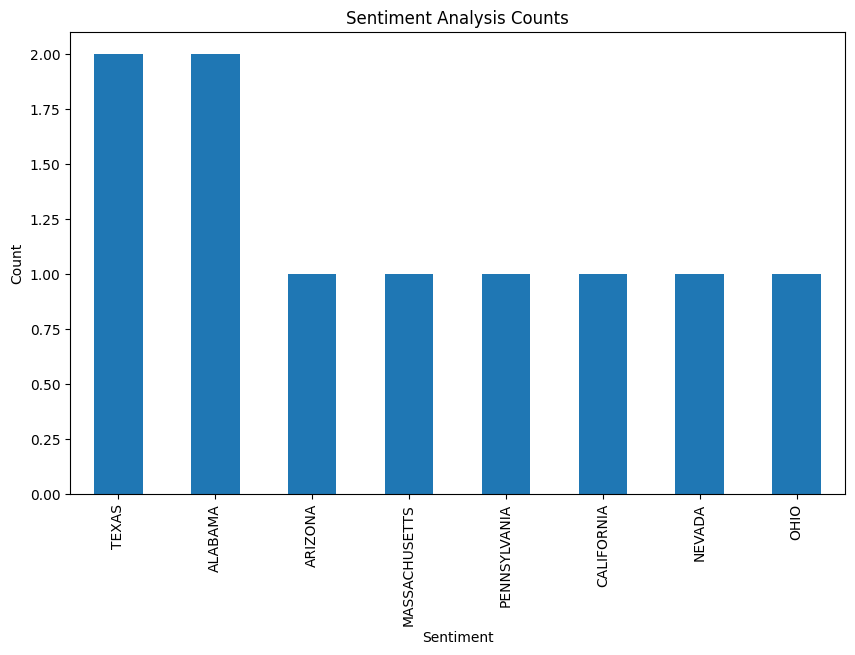

In [99]:
import matplotlib.pyplot as plt

sentiment_counts = licenses_df['State'].value_counts()

plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Analysis Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()